In [270]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

ValueError: GPU setup must happen before importing TensorFlow

In [195]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt
from sklearn.manifold import TSNE

from general_tools.in_out.basics import unpickle_data
from general_tools.in_out import create_dir
from general_tools.notebook.tf import reset_tf_graph

from general_tools.plotting import stack_images_horizontally, stack_images_in_square_grid
from general_tools.clustering.plt import plot_2d_embedding_in_grid_greedy_way, plot_2d_embedding_in_grid_forceful

from geo_tool import Point_Cloud

import tf_lab.point_clouds.in_out as pio

from tf_lab.data_sets.shape_net import  pc_loader as sn_pc_loader

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.in_out.basics import read_saved_epochs
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import pairwise_distances

from general_tools.clustering.dist import incremental_farthest_sampling, evaluate_solution
from general_tools.in_out.basics import files_in_subdirs

from harnessing_geometric_triplets import make_triplets, save_triplets, plot_triplets

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
def detect_outliers(features, outlier_fraction, random_seed):
    '''
    '''
    clf = IsolationForest(max_samples=100, max_features=64, random_state=random_seed, contamination=outlier_fraction)
    clf.fit(features)
    y_pred = clf.predict(features)
    outliers = np.where(y_pred == -1)[0]
    print 'Outliers detected = ', len(outliers)
    return outliers

In [5]:
random_seed = 42
outlier_fraction = 0.20 # Percent of data instances that will be automatically disreguarded.
# n_exemplars = 140       # Source instances that will be used to create contrasting triplets.
top_data_dir = top_data_dir = '/orions4-zfs/projects/optas/DATA/'

In [6]:
# load AE model
class_name = 'chair'
syn_id = snc_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '12' # 128 bottleneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))

if ae_conf.train_dir != ae_net_dir:
    ae_conf.train_dir = ae_net_dir
    ae_conf.save(osp.join(ae_conf.train_dir, 'configuration'))
    
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [7]:
# Load Raw Point-Clouds of class
n_pc_samples = 2048
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

pclouds_path = osp.join(pclouds_path, syn_id)
file_names = [f for f in files_in_subdirs(pclouds_path, '.ply')]
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778
6778 files containing complete point clouds were found.


In [8]:
pcloud_data = PointCloudDataSet(pclouds, labels=model_ids, init_shuffle=False)
_, latent_codes, temp_names = ae.embedding_at_tensor(pcloud_data, ae_conf, tensor_name='bottleneck')
assert(np.alltrue(temp_names==model_ids))

In [9]:
top_image_dir = '/orions4-zfs/projects/optas/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/'
top_image_dir = osp.join(top_image_dir, syn_id)
image_view_tag = 'image_p020_t337_r005.png'

top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/3d_neighbs_as_context/pilot_triplets_3/'
top_out_dir = osp.join(top_out_dir, 'outlier_frac_' + str(int(outlier_fraction * 100)))
create_dir(top_out_dir)

'/orions4-zfs/projects/optas/DATA/OUT/3d_neighbs_as_context/pilot_triplets_3/outlier_frac_20'

In [10]:
all_pdists = pairwise_distances(latent_codes)
outliers = detect_outliers(latent_codes, outlier_fraction, random_seed)

Outliers detected =  1356


In [87]:
n = len(latent_codes)
exclude_list = []
targets = np.setdiff1d(np.arange(n), exclude_list)
index, _ = find_nearest_neighbors(latent_codes[targets], k=2)
index = targets[index]

In [241]:
from collections import Counter
count = Counter(index.flatten())
n_nodes = 1000
selected = [i[0] for i in count.most_common(n_nodes)]
exclude_list = np.setdiff1d(np.arange(n), selected)

In [99]:
def visualize_shapes_generator(data_to_vis, model_ids, top_image_dir, image_view_tag):
    for i in data_to_vis:
        image_files = []
        try:
            for j in i:
                image_files.append(osp.join(top_image_dir, model_ids[j], image_view_tag))
        except:
            image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))
            
        yield stack_images_horizontally(image_files)

In [100]:
vis_g1 = visualize_shapes_generator(selected, model_ids, top_image_dir, image_view_tag)

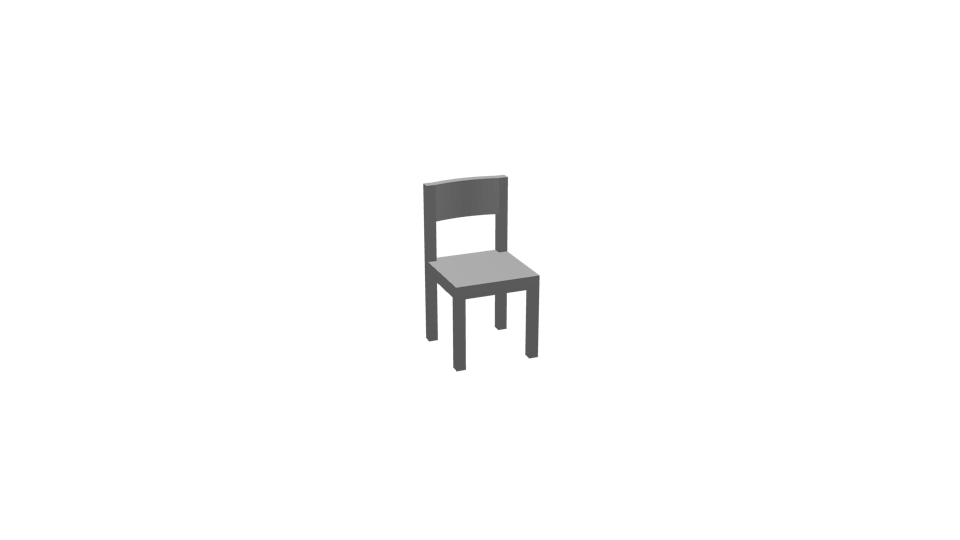

In [185]:
# vis_g1.next()

In [196]:
plot_tsne = True
tsne_of = selected
if plot_tsne:
    # Plot TSNE of examplars.
    model = TSNE(n_components=2, random_state=random_seed, init='pca')
    tsne_coords = model.fit_transform(latent_codes[selected])

    # Make a list with the file-names of all to be used images.
    image_files = []
    for i in tsne_of:
        image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))

    save_file = osp.join(top_out_dir, 'tsne_selected_nodes_max_deg.png')
    small_dim = 400
    big_dim = int(np.ceil(np.sqrt(len(selected)))) * small_dim    
    plot_2d_embedding_in_grid_forceful(tsne_coords, image_files, big_dim, small_dim, save_file=save_file);

In [203]:
len(np.unique(model_ids[tsne_of]))


1000

In [242]:
pdists_ = all_pdists[selected]
# pdists_ = np.triu(all_pdists, 0) 
pdists_ = np.triu(pdists_, 0) 
pdists_ = pdists_[pdists_ > 0]
too_close_threr = np.percentile(pdists_, 0.01)
too_far_thres = np.percentile(pdists_, 50)

In [ ]:
ex

In [205]:
def close_triplets_gen(all_pdists, exclude_list, min_dist, vis=False):
    exclude_list = np.unique(exclude_list)
    n = all_pdists.shape[0]
    
    targets = np.setdiff1d(np.arange(n), exclude_list)
    for i in targets:            
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, exclude_list, assume_unique=True)
        candidates = np.setdiff1d(candidates, i, assume_unique=True)
        relevant_dists = all_pdists[i, candidates]
        big_enough = relevant_dists > min_dist
        relevant_dists = relevant_dists[big_enough]
        candidates = candidates[big_enough]        
        aso = np.argsort(relevant_dists)
        aso = candidates[aso]
        triplet = [i, aso[0], aso[1]]        
        if vis:            
            image_files = []
            image_files.append(osp.join(top_image_dir, model_ids[triplet[0]], image_view_tag))
            image_files.append(osp.join(top_image_dir, model_ids[triplet[1]], image_view_tag))
            image_files.append(osp.join(top_image_dir, model_ids[triplet[2]], image_view_tag))
            yield triplet, stack_images_horizontally(image_files)
        else:
            yield triplet

            
def far_triplets_gen(all_pdists, exclude_list, max_dist):
    exclude_list = np.unique(exclude_list)
    n = all_pdists.shape[0]
    for i in range(n):
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, exclude_list, assume_unique=True)
        candidates = np.setdiff1d(candidates, i, assume_unique=True)
        relevant_dists = all_pdists[i, candidates]
        small_enough = relevant_dists < max_dist
        relevant_dists = relevant_dists[small_enough]
        candidates = candidates[small_enough]
        aso = np.argsort(relevant_dists)
        aso = candidates[aso]
        image_files = []
        image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[aso[-2]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[aso[-1]], image_view_tag))
        yield stack_images_horizontally(image_files)

In [206]:
from general_tools.clustering.convenience import find_nearest_neighbors

In [19]:
n = len(latent_codes)
targets = np.setdiff1d(np.arange(n), exclude_list)
index, _ = find_nearest_neighbors(latent_codes[targets], k=2)
index = targets[index]

In [30]:
exclude_list = np.setdiff1d(np.arange(n), np.unique(index.flatten()))

In [243]:
# far_tr_gen = far_triplets_gen(all_pdists, exclude_list, too_far_thres)
close_tr_gen = close_triplets_gen(all_pdists, exclude_list, too_close_threr, vis=True)
# all_close_tr = [t for t in close_tr_gen]

In [244]:
len(all_close_tr)

1000

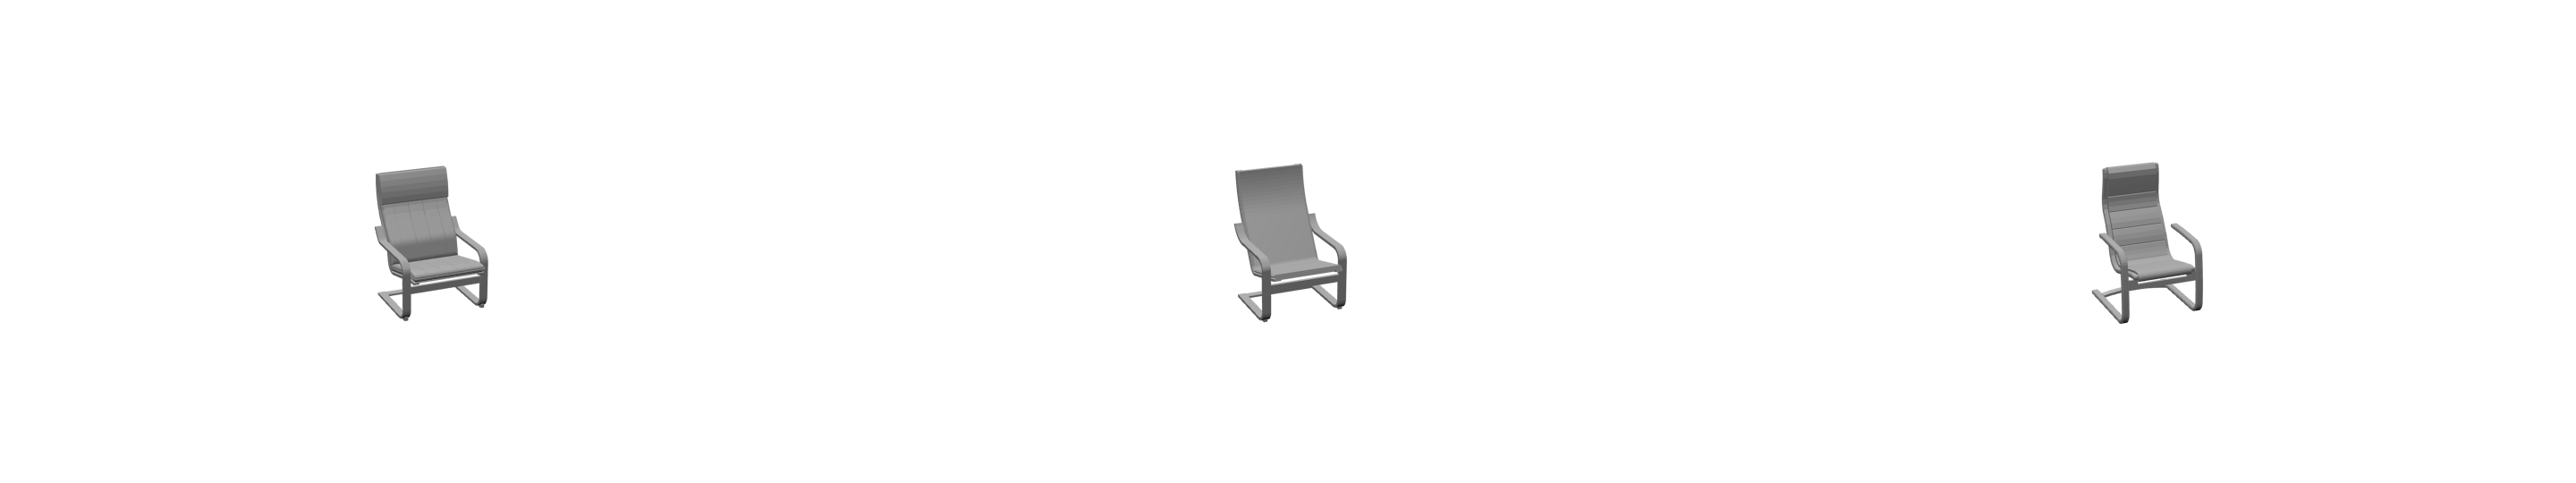

In [269]:
_ , im = close_tr_gen.next()
im

In [1034]:
from collections import Counter
c = Counter(np.hstack(np.vstack(a)).tolist())
most_common = [i[0] for i in c.most_common(20)]

In [1184]:
least_com_gen = visualize_shapes_generator(not_seen, model_ids, top_image_dir, image_view_tag)
most_com_gen = visualize_shapes_generator(most_common, model_ids, top_image_dir, image_view_tag)

In [1206]:
# least_com_gen.next()
# most_com_gen.next()

StopIteration: 

In [827]:
collisions = dict()
for i in range(len(all_pdists)):
    too_close = np.setdiff1d(np.where(all_pdists[i, :] < too_close_threr)[0], i)
    if len(too_close) > 0:
        collisions[i]  = too_close

In [828]:
def next_collision(collisions): 
    for k in collisions.keys():
        yield k
g = next_collision(collisions)
shapes_with_collision = collisions.keys()
print len(shapes_with_collision)

675


In [829]:
def select_from_collisions(collisions):
    select = set()
    exclude = set()
    for key in collisions.keys():
        if key not in exclude:
            select.add(key)
        exclude.add(key)
        exclude.update(collisions[key])
    return list(select), list(exclude)

In [538]:
a, b = select_from_collisions(collisions)
def foo():
    for item in a:        
        image_files = []
        check_with  = np.setdiff1d(a, item)
        item_c = np.argmin(all_pdists[item, check_with])
        item_c = check_with[item_c]
        image_files.append(osp.join(top_image_dir, model_ids[item], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[item_c], image_view_tag))
        yield stack_images_horizontally(image_files)

In [590]:
n = all_pdists.shape[0]
def checking_tr(select_from, exclude_list):
    for i, s in enumerate(select_from):        
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, exclude_list)
        candidates = np.setdiff1d(candidates, s)        
        aso = np.argsort(all_pdists[s, candidates])                        
        aso = candidates[aso]
        image_files = []
        image_files.append(osp.join(top_image_dir, model_ids[s], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[aso[0]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[aso[1]], image_view_tag))
        yield stack_images_horizontally(image_files)

In [ ]:

# len(collisions.keys())



# exclude = outliers
# fps_sol = incremental_farthest_sampling(all_pdists, n_exemplars, exclude, random_seed)

# exclude = np.unique([np.hstack([collisions.keys(), outliers])])

# fps_sol = incremental_farthest_sampling(all_pdists, n_exemplars, exclude, random_seed)

# print 'Average Min Distance of FPS exemplars:', evaluate_solution(latent_codes[fps_sol])

In [591]:
lala = checking_tr(a, b)

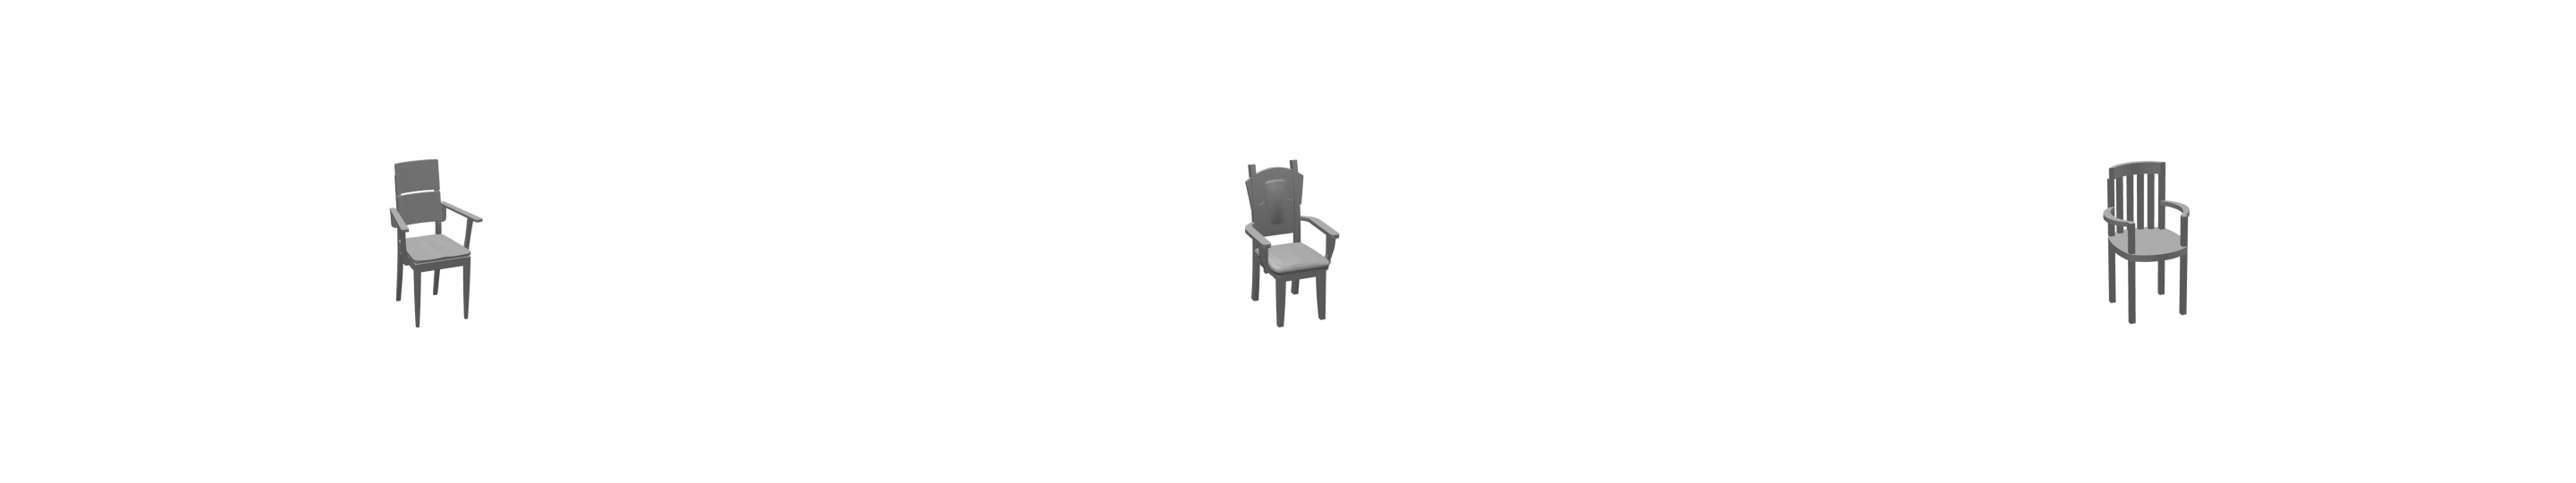

In [601]:
lala.next()

In [325]:
3895 in set(a)

False

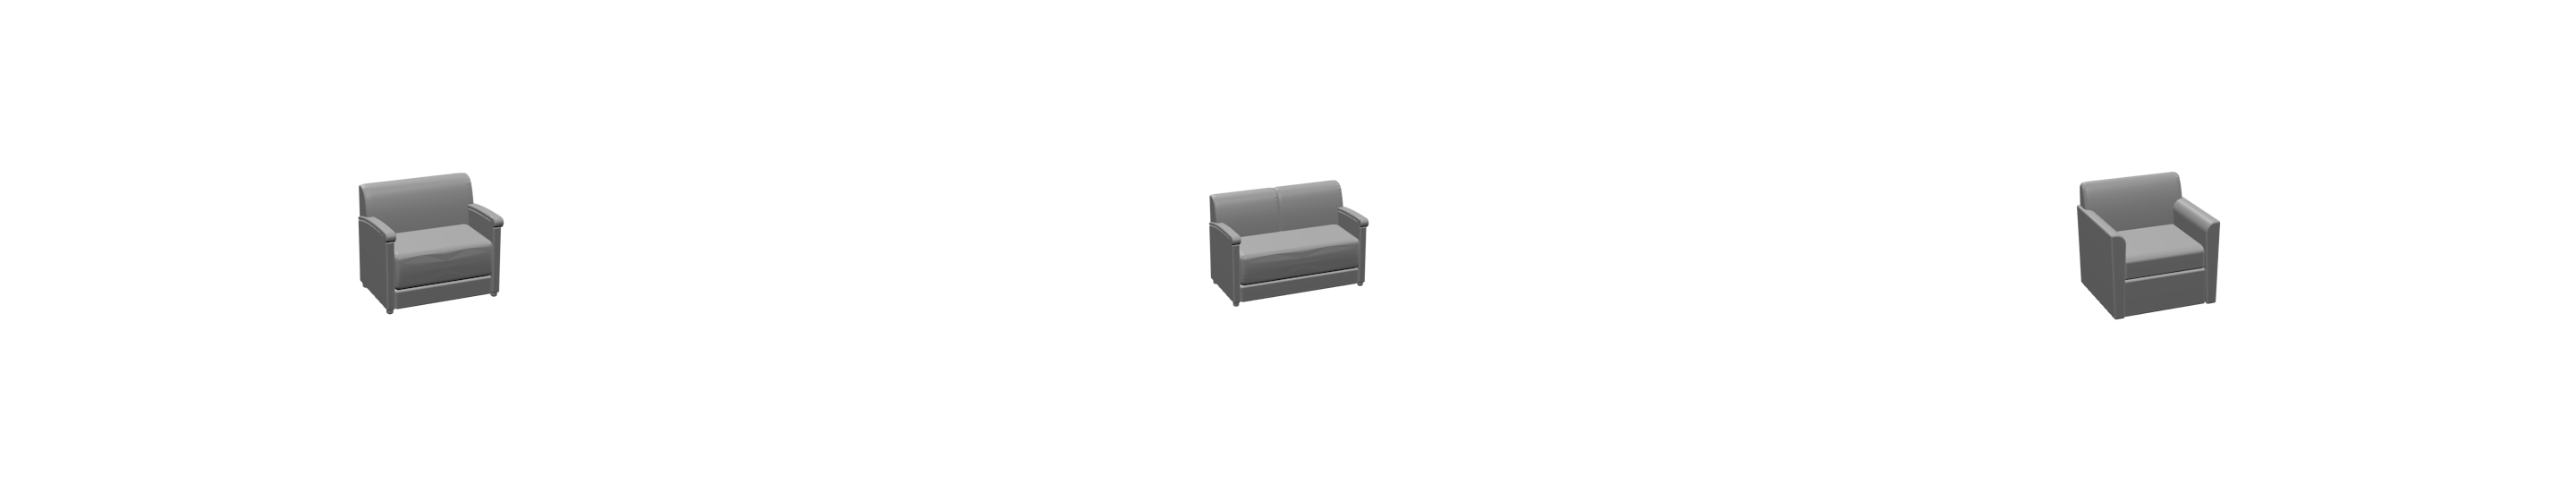

In [650]:
no_constraint_gen.next()

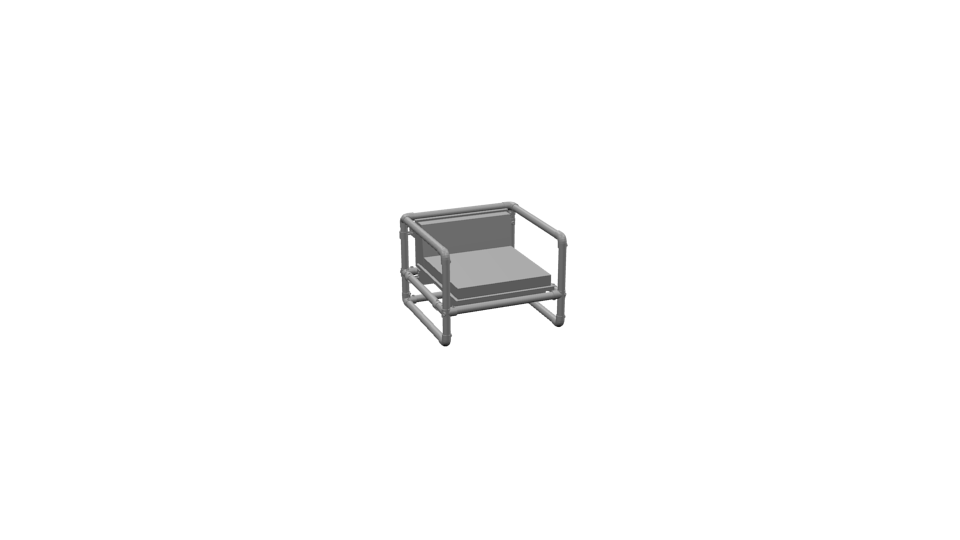

In [818]:
vis_g1.next()

In [327]:
image_files = []
for i in outliers:
    print i
    image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))

stack_images_in_square_grid(image_files)

6145
3895


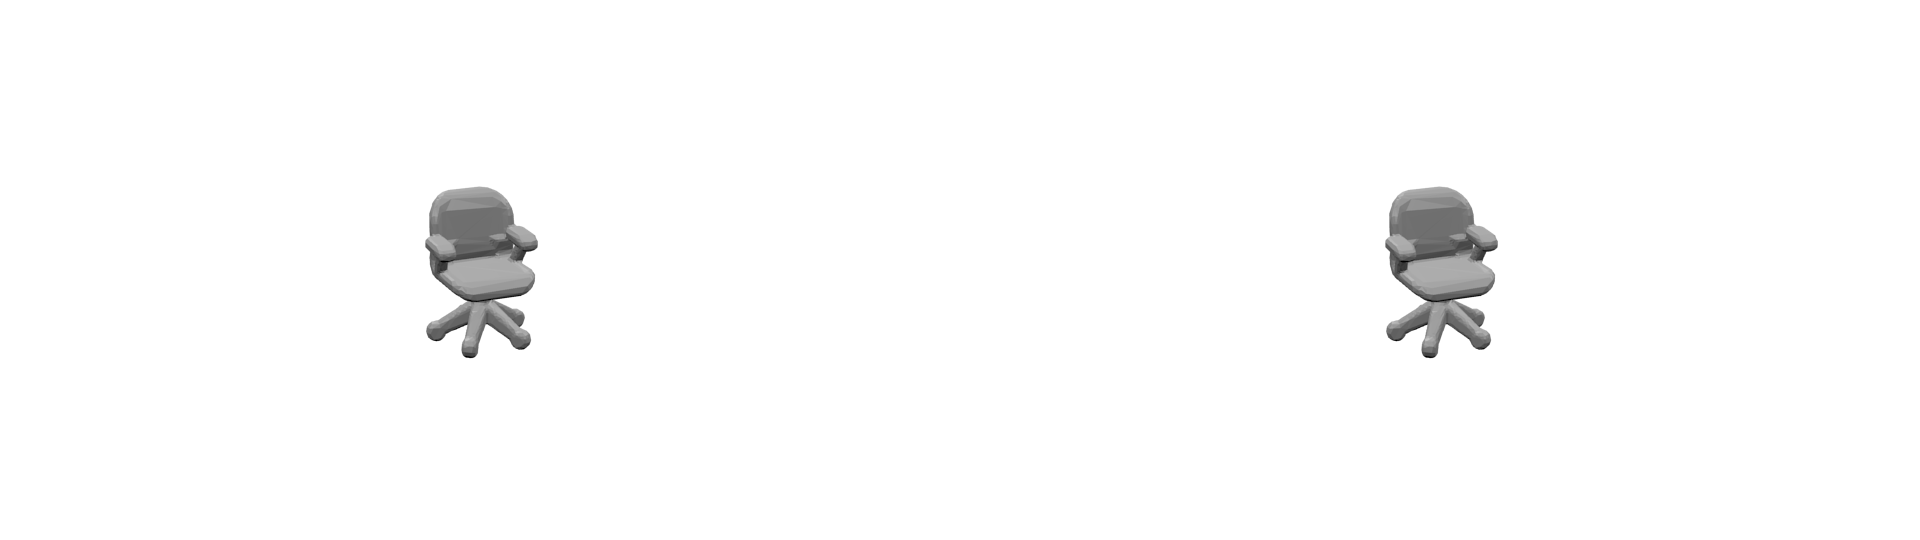

In [320]:
image_files = []
check = g.next()

image_files.append(osp.join(top_image_dir, model_ids[check], image_view_tag))
print check
for c in collisions[check]:
    image_files.append(osp.join(top_image_dir, model_ids[c], image_view_tag))
    print c

stack_images_horizontally(image_files)

In [102]:
# a = set(collisions.keys())
# b = set(outliers)
# len(a.intersection(b))

104

In [20]:
rule = 'closest_nn'
triplets = make_triplets(fps_sol, all_pdists, outliers, rule)
triplet_out_dir = create_dir(osp.join(top_out_dir, rule, 'data'))
save_triplets(triplets, top_image_dir, triplet_out_dir, model_ids)
triplet_out_dir = create_dir(osp.join(top_out_dir, rule, 'images'))
plot_triplets(triplets, top_image_dir, triplet_out_dir, model_ids)

[2725, 4016, 4260]

In [28]:
triplet_out_dir = create_dir(osp.join(top_out_dir, rule))
triplets = []
for rule in ['closest_nn', 'one_far', 'both_far']:
    triplets.append(make_triplets(fps_sol, all_pdists, outliers, rule))

triplet_out_dir = create_dir(osp.join(top_out_dir, 'all_rules', 'images'))
plot_triplets_in_multiple_contexts(triplets, top_image_dir, triplet_out_dir, model_ids)